In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
# from nltk.tokenize import word_tokenize as wt 
# from collections import Counter
# from wordcloud import WordCloud, STOPWORDS
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# import textblob
import string
import re
import spacy

#### **Spacy exploration**

In [2]:
nlp = spacy.load("en_core_web_sm")

#### **Generating sentiments**

**Plan of Action**

- Load the data
- Drop irrelevant columns
- Drop duplicates and null values
- Memory saving by converting to respective data types
- Perform EDA on uncleaned text data

**Cleaned text**
- Clean the text data
    - Using the preprocess function
    - Perform EDA

In [3]:
dataframe = pd.read_csv('../data/amazon_reviews.csv')      

In [4]:
dataframe.sample(n=2,random_state=42)

,id,profile_name,review_score,review_title,review_date,product_colour,the_review
7270,7264,Beatris Bonilla,1.0,Disappointed,2021-09-11,Black,I used this mouse once and it died after an ho...
15907,853,Edmund Maximillian Watkins,5.0,Nice portable speaker at this price point,2021-08-15,Multicolor,I bought I bought it as a gift for my husband ...


In [5]:
dataframe.drop(['id','profile_name','product_colour'], axis=1, inplace=True)

# Test without dropping id,profile_name, product_colour or review_title

In [6]:
dataframe.shape

(18409, 4)

In [7]:
dataframe.isna().sum() 

review_score      0
review_title    223
review_date       0
the_review      534
dtype: int64

In [8]:
dataframe.duplicated().sum() 

43

- We have some nulls and duplicaated values.
- Next we drop the nulls and duplicated values

In [9]:
dataframe_ = dataframe.copy()
# Dropping nulls
dataframe_.dropna(inplace=True)
dataframe_.shape

(17678, 4)

In [10]:
dataframe_.isna().sum() # No nulls

review_score    0
review_title    0
review_date     0
the_review      0
dtype: int64

In [11]:
dataframe_.duplicated().sum()

38

In [12]:
# Dropping duplicates
dataframe_.drop_duplicates(inplace=True)
dataframe_.shape

(17640, 4)

In [13]:
dataframe_.duplicated().sum() # No duplicates

0

In [14]:
dataframe_.describe()

,review_score
count,17640.000000
mean,3.627551
std,1.686209
min,1.000000
25%,2.000000
50%,5.000000
75%,5.000000
max,5.000000


In [15]:
dataframe_.dtypes

review_score    float64
review_title     object
review_date      object
the_review       object
dtype: object

In [16]:
# review_title_length = [len(b.split()) for b in dataframe_.loc[:,"review_title"]]
import math 
the_review_length = [math.floor(len(b.split())) for b in dataframe_.loc[:,"the_review"]]

In [17]:
# dataframe_['review_title_length'] = review_title_length
dataframe_['the_review_length'] = the_review_length 

In [18]:
dataframe_.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17640 entries, 0 to 18332
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   review_score       17640 non-null  float64
 1   review_title       17640 non-null  object 
 2   review_date        17640 non-null  object 
 3   the_review         17640 non-null  object 
 4   the_review_length  17640 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 8.2 MB



| Data-Type | Precision |
| ----------- | ----------- |
float16   | 3
float32   | 6
float64   | 15
float128  | 18

--------------------------------- 


|Data type |min|max|
| ----------- | ----------- |----------- |
|int8|-128|127|
|int16|-32768|32767|
|int32|-2147483648|2147483647|
|int64|-9223372036854775808|9223372036854775807|

In [19]:
def memory_magment(df):
    for col in df.columns:
        col_type = df[col].dtype

        if col_type != np.object:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8) # int 8
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16) # int 16
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)  # in 32
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64) # int 64 
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else: 
                    df[col] = df[col].astype(np.float64)
    return df
df_memory = dataframe_.copy()
df_memory = memory_magment(df_memory)    

In [20]:
df_memory.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17640 entries, 0 to 18332
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   review_score       17640 non-null  float16
 1   review_title       17640 non-null  object 
 2   review_date        17640 non-null  object 
 3   the_review         17640 non-null  object 
 4   the_review_length  17640 non-null  int16  
dtypes: float16(1), int16(1), object(3)
memory usage: 8.0 MB


### **EDA -1: Text analysis on uncleaned text**

In [21]:
df_eda = df_memory

In [22]:
df_eda.columns

Index(['review_score', 'review_title', 'review_date', 'the_review',
       'the_review_length'],
      dtype='object')

In [23]:
df_eda['year'] = df_eda['review_date'].apply(lambda x: x.split("-")[0])
df_eda['month'] = df_eda['review_date'].apply(lambda x: x.split("-")[1])

Text(0.5, 1.0, 'Review Score Count')

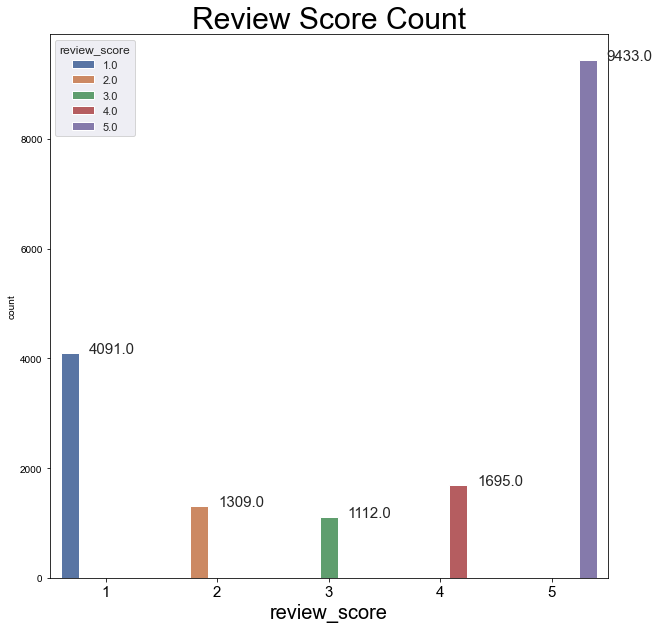

In [24]:
fig,ax = plt.subplots(figsize=(10,10))
sns.set_theme(style="darkgrid")
sns.countplot(data=df_eda,x='review_score',hue='review_score')
# ax.tick_params(axis="x",rotation=-45)

ax.set_xticklabels(fontsize=15,labels=[1,2,3,4,5])


for p in ax.patches:
   ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01), size=15)
         
ax.set_xlabel("review_score", fontdict={'fontsize':20})
ax.set_title("Review Score Count", fontdict={'fontsize':30})

The following can be derived from the graph above;
- review_score of 5 is the highest in the dataset, followed by 1, 4 and 3.

In [25]:
def plotting_bar_date(x:str,group:str):
    try:
        grouped_agg = df_eda.groupby(group)[x].value_counts().to_frame('total_counts').reset_index()
        fig,ax = plt.subplots(1, figsize=(20,10))

        colors = [
            'purple','green',
            'blue','pink',
            'brown','red',
            'yellow','orange',
            'teal','purple',
            'tan','aqua',
                ]
        my_palette = sns.xkcd_palette(colors)
        sns.set_theme(style="darkgrid")
        sns.barplot(data=grouped_agg, x=group, y=f'total_counts', palette=my_palette,hue=x)


        # ax.set_title(f'Number of reviews a {x}',fontsize=30)
        ax.set_xlabel(f"{group}", fontdict={'fontsize':20})
        ax.set_ylabel(f"total_counts in {x}", fontdict={'fontsize':20})
    except KeyError:
            print(f"The wrong Key was passed\nPlease look are the information below\n")
            df_eda.info(memory_usage='deep')

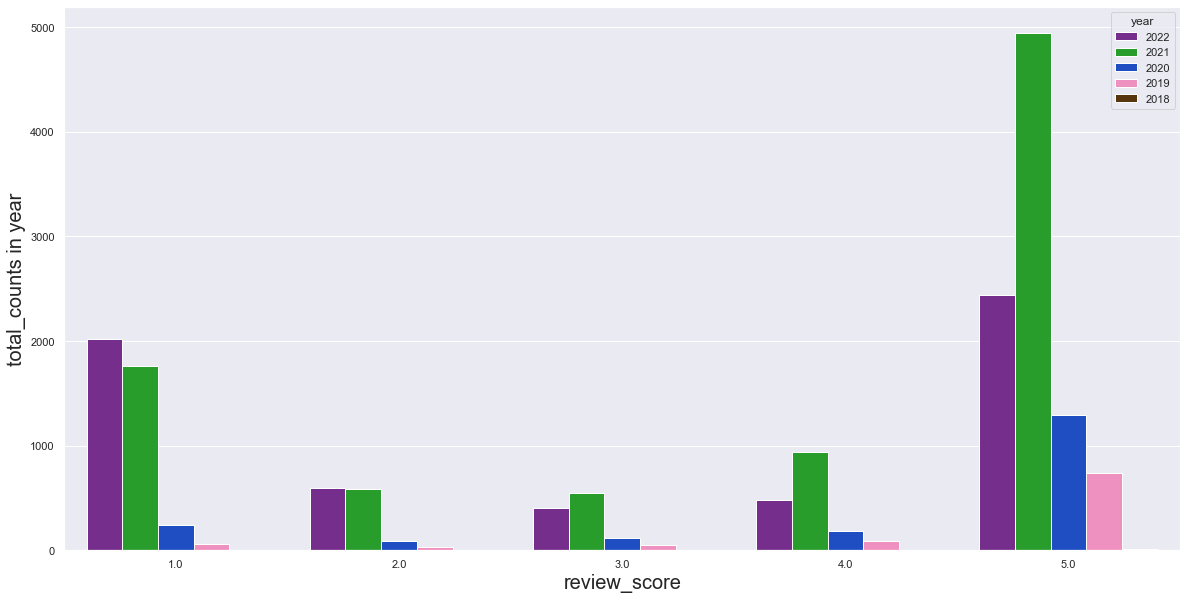

In [26]:
plotting_bar_date(group='review_score',x='year') 

The following can be derived from the graph above;

- Amongst the mouse, keyboard, headset, speaker datasets, in the year 2021, we can see a collective high amount of 5/5 reviews followed by 2022
- We can see that in the year 2022 and 2021, has a high amount of 1 star reviews
- We can see that  2-4 star reviews for all the products are quite few; could mean that customers are thorough with their user experience with the purchased products, **IT IS EITHER GOOD OR BAD**

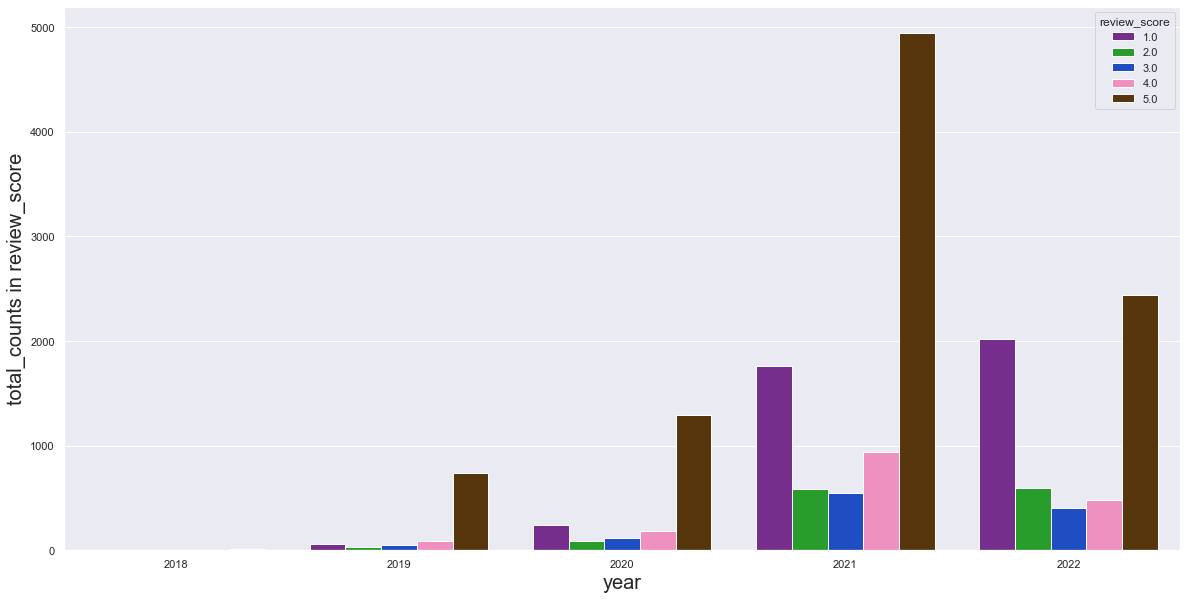

In [27]:
plotting_bar_date(group='year',x='review_score') 

The following can be derived from the graph above;

- Little to not much reviews could be found from years 2018-2019; could be that the products only grew into popularity in 2020 or clearing out of the database from Amazon or due to removal of null values and duplicates; This last point could be highly unlikely because initial size of the data was 18409 data points and before downsizing it to 17340 data points after removal of null values and duplicates.

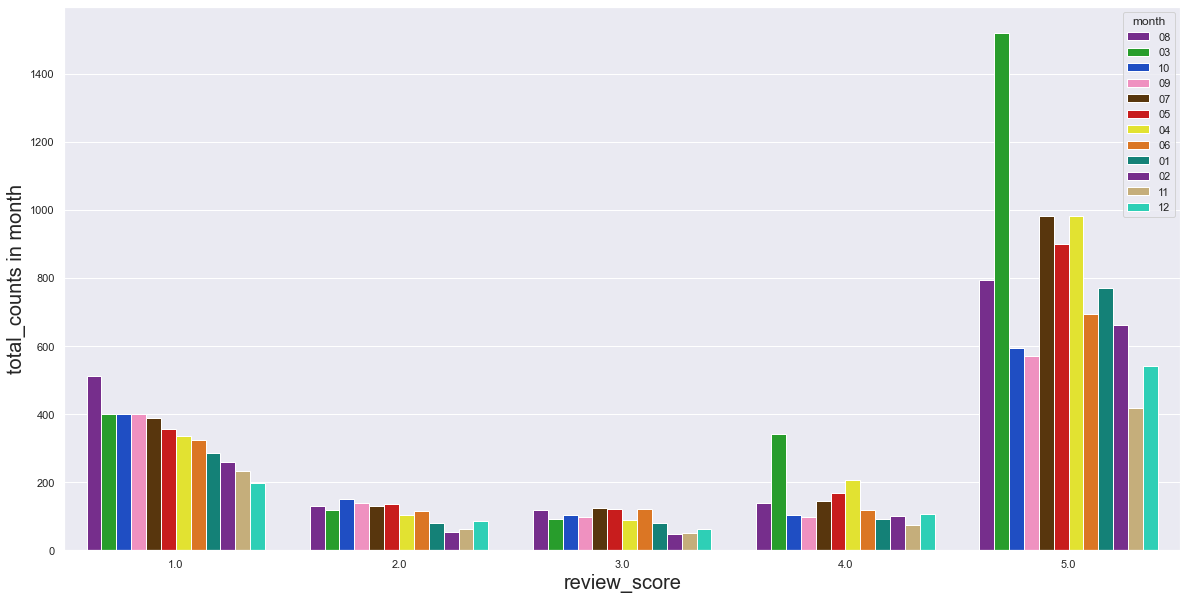

In [28]:
plotting_bar_date(group='review_score',x='month') 

The following can be derived from the graph above;

- 4 & 5 star reviews came mostly within the month of March 
- 1 star reviews came mostly from August
- 2-3 star reviews have fluctuations within the months.

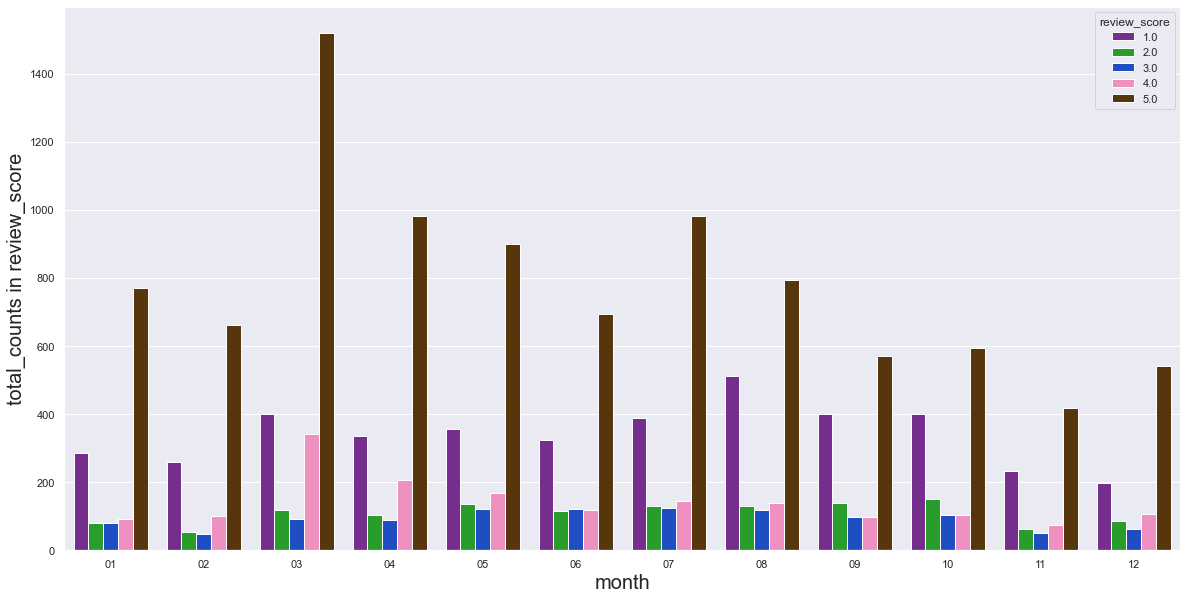

In [29]:
plotting_bar_date(group='month',x='review_score') 

The following can be derived from the graph above;

- This confirms the statements from the previous graph.

In [30]:
# For Pie Chart
df_review_score_count = df_eda['review_score'].value_counts()
df_review_score_count= df_review_score_count.to_frame().reset_index()
df_review_score_count.rename(columns={'index':'review_score','review_score':'total_count'}, inplace=True)

df_review_score_count

,review_score,total_count
0,5.0,9433
1,1.0,4091
2,4.0,1695
3,2.0,1309
4,3.0,1112


In [31]:
import plotly.graph_objects as go
# fig = px.pie(df_review_score_count, values='total_count', names='review_score', title='review_score')
# fig.show()


colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen', 'lightblue']

fig = go.Figure(data=[go.Pie(labels=df_review_score_count.review_score,
                             values=df_review_score_count.total_count)])


fig.update_layout(
width=1000,
title={"x": 0.5, "xanchor":"center", 
"font_family":"Times New Roman", 
"text":"Review Score"})

fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=20,
                  marker={'colors':colors, 'line_color':'#000000','line_width':2})

fig.show()


The following can be derived from the graph above;

- 5 star reviews makes more that half of the dataset; 53.5%
- 1 star reviews make up 23.5% of the dataset
- 4 star reviews make up 9.61% of the dataset
- 2 star reviews make up 7.42% of the dataset
- 3 star reviews make up 6.3% of the dataset

In [32]:
df_eda.columns

Index(['review_score', 'review_title', 'review_date', 'the_review',
       'the_review_length', 'year', 'month'],
      dtype='object')

In [33]:
df_eda.groupby('review_score')[['the_review_length']].agg([('Count','count'),('Max','max'),('Min','min'), ("Mean",'mean'),('Deviation','std'),('Skew','skew')]).reset_index()

review_score the_review_length                                         
                           Count  Max Min       Mean  Deviation      Skew
0          1.0              4091  599   1  34.540455  39.262866  3.971877
1          2.0              1309  378   1  32.612681  35.259334  2.959378
2          3.0              1112  312   1  33.756295  34.467676  2.555387
3          4.0              1695  535   1  32.188201  43.033079  4.548172
4          5.0              9433  600   1  30.880738  37.323879  4.104046

The following can be derived from the table above;

**MAX LENGTH**

- The maximum length of 1 star reviews is 599
- The maximum length of 2 star reviews is 378
- The maximum length of 3 star reviews is 312
- The maximum length of 4 star reviews is 535
- The maximum length of 5 star reviews is 600

**MEAN LENGTH**

- The mean length of 1,2,3,4,5 star reviews is fall within the range of 30-35 (approximately)

**DEVIATION LENGTH**

- The Deviation length from mean for 1,2,3,4,5 star reviews falls within the  range  of 34-43 (approximately)

**SKEWNESS**

- 5,4 and 1 star reviews have high skewness, probably due to their max length.
- 2 and 3 star reviews have low skewness compared to others

In [34]:
nums = df_eda[['the_review_length']]

In [35]:
def outliers(data,col):
    Q_1 = np.quantile(data[col],0.25)
    Q_3 = np.quantile(data[col],0.75)
    IQR = Q_3 - Q_1 
    lower_bound = Q_1 - (1.5* IQR)
    upper_bound = Q_3 + (1.5* IQR)
    IQR_values = ((data[col] >= Q_1) & (data[col] <= Q_3)).sum()
    outliers_beyond_upper_bound = (data[col] > upper_bound).sum()
    outliers_below_lower_bound = (data[col]  < lower_bound).sum()
    print(f"IQR value for column {col} is: {IQR}")
    print(f"Q_1 value for column {col} is: {Q_1}")
    print(f"Q_3 value for column {col} is: {Q_3}")
    print(f"Lower bound value for column {col} is: {lower_bound}")
    print(f"Upper bound value for column {col} is: {upper_bound}")
    print(f"The number of values within the IQR for {col} is {IQR_values}")
    print(f"The number of outliers beyond the upper bound for {col} is {outliers_beyond_upper_bound}")
    print(f"The number of outliers below the lower bound for {col} is {outliers_below_lower_bound}\n")

In [36]:
def review_scores_two():
    try:
        scores = [1,2,3,4,5]
        for index,val in enumerate(scores):
            value = df_eda.review_score == val # The boolean
            the_score = df_eda.loc[value] # New dataframe
            colors_list = ['red',
                    'darkgreen',
                    'chocolate','deepskyblue','darkmagenta',
                  ]
            # Making the box plot
            fig,ax = plt.subplots(1,2, figsize=(20,5))
            sns.boxplot(data=the_score,x='the_review_length',ax=ax[0],color=colors_list[index])
            sns.boxenplot(data=the_score,x='the_review_length',ax=ax[1],color=colors_list[index])
            ax[0].set_title(f"The box plot of review_score {val} with the_review_length",fontdict={'size':15})
            ax[1].set_title(f"The boxen plot of review_score {val} with the_review_length",fontdict={'size':15})
            plt.subplots_adjust(wspace=0.1)

            # The outliers
            the_score_outlier = the_score[['the_review_length']]
            for i in the_score_outlier.columns:
                print(f"review_score: {val}")
                outliers(the_score_outlier, i)
    except ValueError:
            print(f"The wrong Key was passed\nPlease look are the information below\n")
            the_score.info(memory_usage='deep')

review_score: 1
IQR value for column the_review_length is: 33.5
Q_1 value for column the_review_length is: 10.5
Q_3 value for column the_review_length is: 44.0
Lower bound value for column the_review_length is: -39.75
Upper bound value for column the_review_length is: 94.25
The number of values within the IQR for the_review_length is 2061
The number of outliers beyond the upper bound for the_review_length is 238
The number of outliers below the lower bound for the_review_length is 0

review_score: 2
IQR value for column the_review_length is: 33.0
Q_1 value for column the_review_length is: 10.0
Q_3 value for column the_review_length is: 43.0
Lower bound value for column the_review_length is: -39.5
Upper bound value for column the_review_length is: 92.5
The number of values within the IQR for the_review_length is 682
The number of outliers beyond the upper bound for the_review_length is 75
The number of outliers below the lower bound for the_review_length is 0

review_score: 3
IQR value 

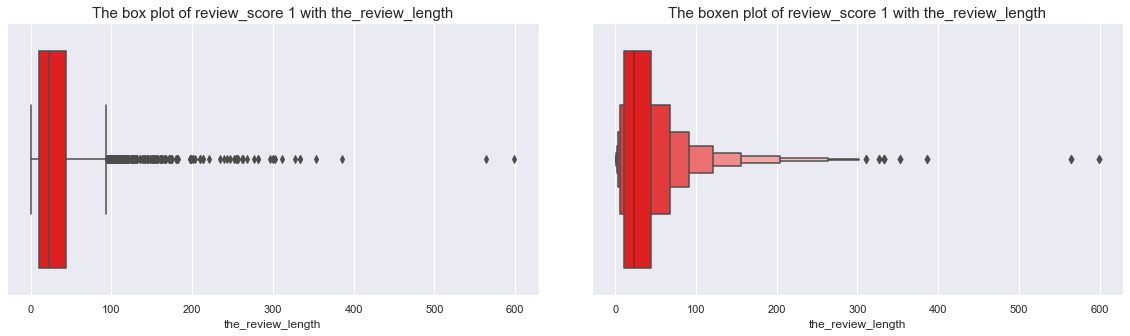

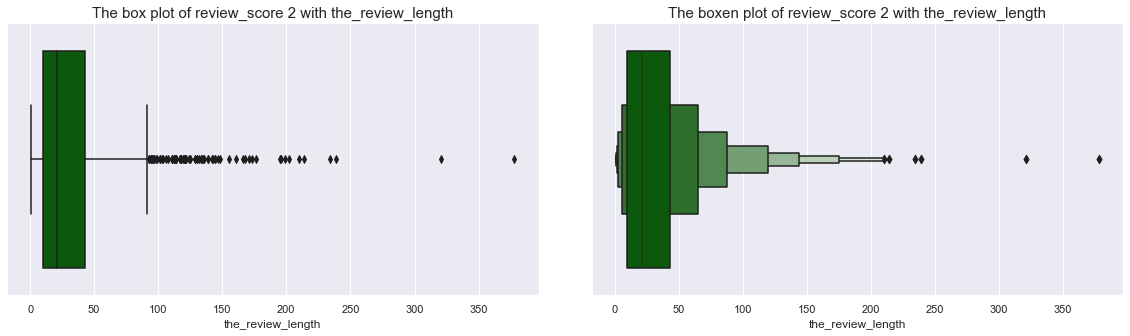

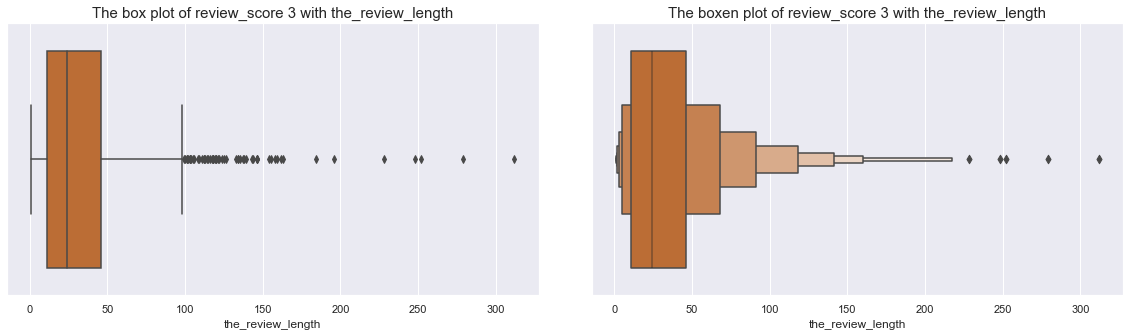

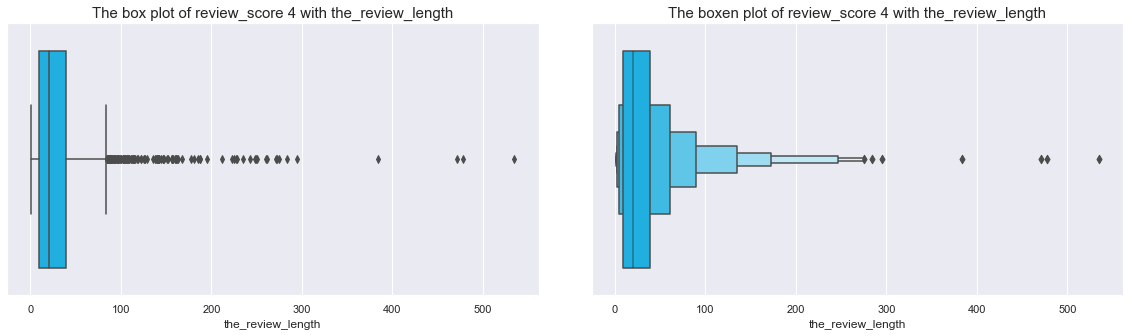

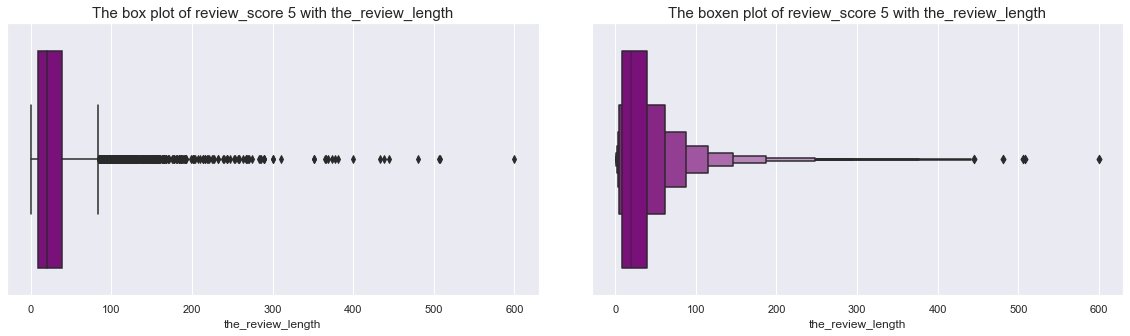

In [37]:
review_scores_two()

The following can be derived from the graph above;

Using the Boxen plot for observations;
- 1 star reviews has a variance that ends in the 300 review length
- 2 star reviews has a variance that slightly passes the 200 review length
- 3 star reviews seems to have a variance that begins from the 150 review length 
- 4 star reviews seems to have a variance that begins from the 200 review length 
- 5 star reviews seems to have a variance that begins from the 250 review length until slightly beyond the 400 review length.

In [38]:
def review_scores_hist_two():
    try:
        scores = [1,2,3,4,5]
        for index,val in enumerate(scores):
            value = df_eda.review_score == val # The boolean
            the_score = df_eda.loc[value] # New dataframe
            colors_list = ['red',
                    'darkgreen',
                    'chocolate','deepskyblue','darkmagenta',
                  ]
            # Making the box plot
            fig,ax = plt.subplots(1, figsize=(20,5))
            sns.histplot(data=the_score,x='the_review_length',kde=True, color=colors_list[index])
            fig.suptitle(f"The Histogram plot of review_score: {val} ",fontsize=15)
            ax.set_title(f"the_review_length skewness: {np.around(the_score['the_review_length'].skew(axis=0),3)}",fontdict={'size':10})
            plt.subplots_adjust(wspace=0.2)
            # plt.subplots_adjust(hspace=0.5)
    except ValueError:
            print(f"The wrong Key was passed\nPlease look are the information below\n")
            the_score.info(memory_usage='deep')

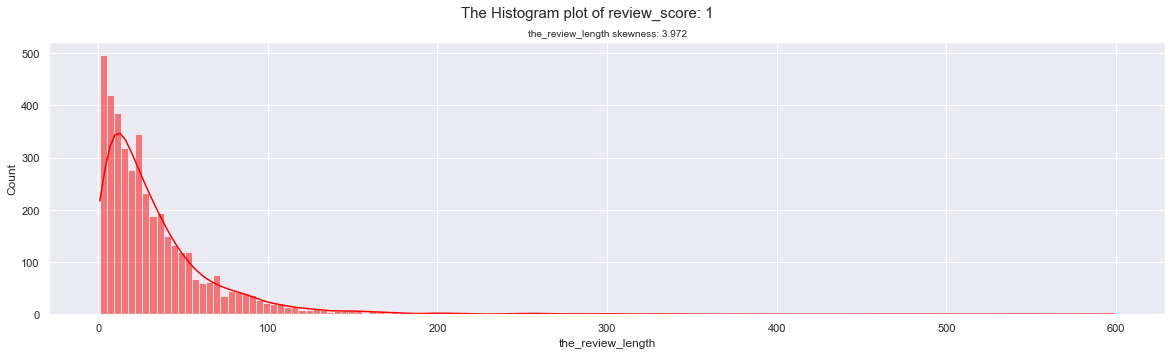

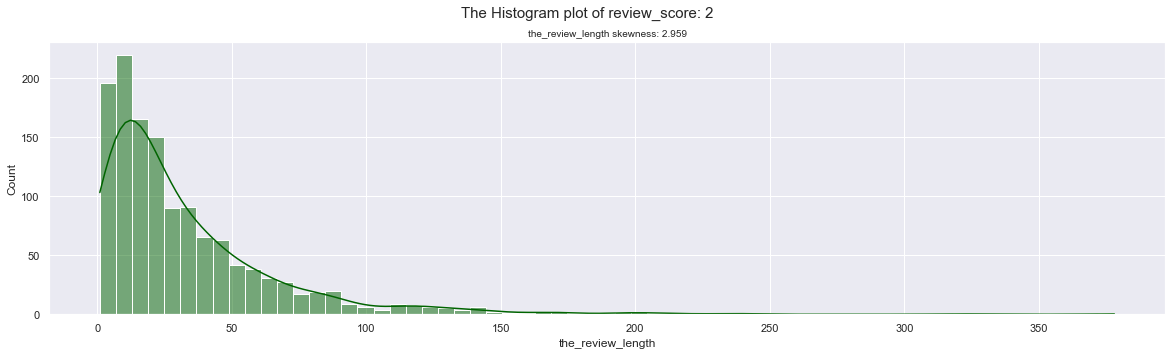

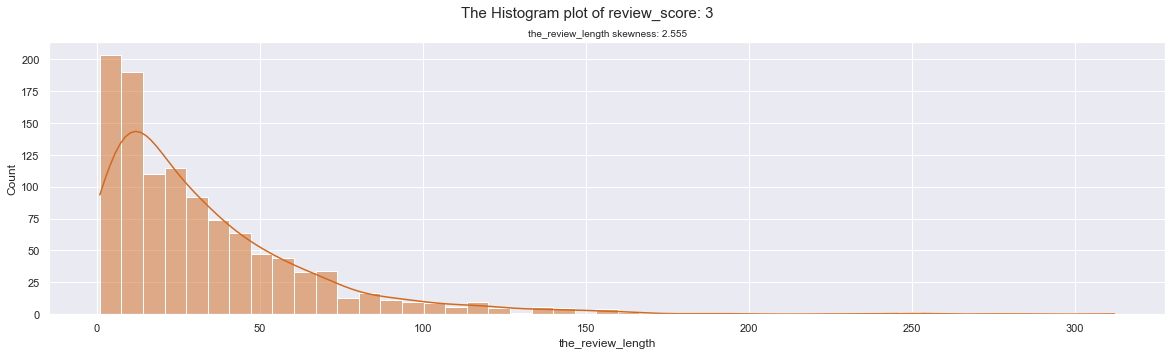

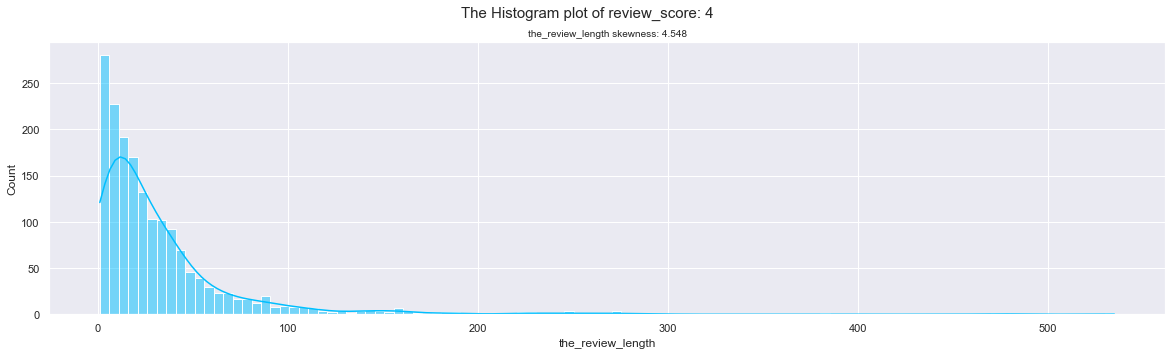

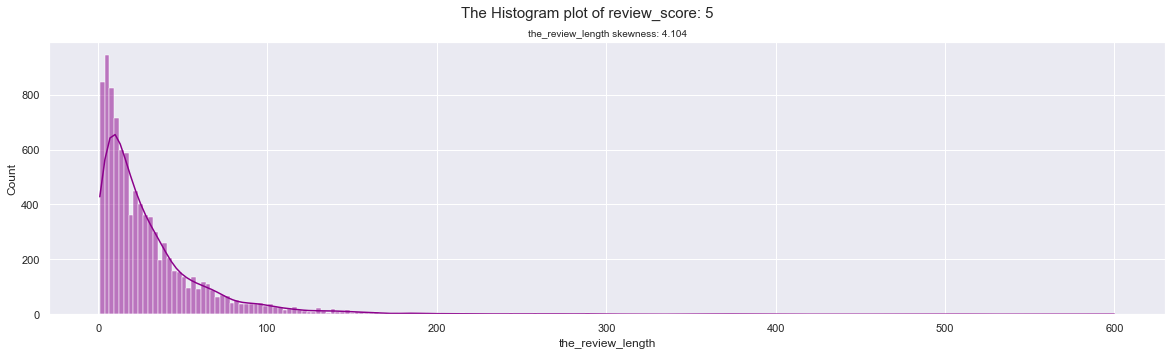

In [39]:
review_scores_hist_two()

The various Histogram plots validates the boxen and box plots

In [40]:
df_eda.head()

,review_score,review_title,review_date,the_review,the_review_length,year,month
0,5.0,Works great,2022-10-29,I wish I would have gotten one earlier. I love...,21,2022,10
1,1.0,I hope you have better luck with this mouse th...,2022-10-29,I've learned this lesson (again). Open the pac...,91,2022,10
2,2.0,Not worth it,2022-10-29,It is so slow and lags find a better option,10,2022,10
3,1.0,Roller ball stopped working within 4 months of...,2022-10-29,Roller ball stopped working within 4 months of...,13,2022,10
4,1.0,The mouse will not hold a charge,2022-10-29,I like the color and size but it’s a few days ...,23,2022,10


In [41]:
export = df_eda[['the_review',"year",'month']]
export

,the_review,year,month
0,I wish I would have gotten one earlier. I love...,2022,10
1,I've learned this lesson (again). Open the pac...,2022,10
2,It is so slow and lags find a better option,2022,10
3,Roller ball stopped working within 4 months of...,2022,10
4,I like the color and size but it’s a few days ...,2022,10
...,...,...,...
18327,Much more than I expected sound is awesome and...,2018,11
18328,Good quality,2018,11
18330,Ok,2018,10
18331,Speaker has clean sound just not loud enough t...,2018,10


### **Exporting the data**

In [42]:
export.to_csv('../model/topic_data.csv',index=False)